# **Exploring how 2020 Oil Price Affected Royalty Revenues **


# -- An exploratory approach




In [ ]:
%reload_ext rpy2.ipython

### Install and Load R Packages

In [ ]:
# Install and load packages
%%capture
%%R
install.packages(c('dplyr', 'magrittr','skimr','tidyr','janitor','ggplot2','readr','datetime','reshape2','readxl'))
x<-c('dplyr', 'magrittr','skimr','tidyr','janitor','ggplot2','readr','datetime','reshape2','readxl')
lapply(x, require, character.only = TRUE)

### Read the price data from; create exchange rate proxy, and WTI-WCS differential

In [38]:
#read price data
%%R
price <- read_excel("oil_sands_2020_project_data.xlsx", sheet = "Prices", col_types = c("date", "numeric", "numeric", "numeric"))


### Create an CDN-USD exchange rate proxy (FX) 

In [ ]:
#Create an  exchange rate proxy (fx) -- by divding USD/bbl by CDN/bbl for each year
%%R
price$FX<-price$WCS_U/price$WCS_C
tail(price,2) 

# A tibble: 2 × 7
    WTI WCS_C WCS_U    fx  year Diff_USD    FX
  <dbl> <dbl> <dbl> <dbl> <dbl>    <dbl> <dbl>
1  41.4  41.3  31.6 0.765  2020     9.78 0.765
2  47.1  47.8  37.3 0.781  2020     9.75 0.781


###Process price data to extract only the year

In [39]:
#Process price data to extract only the year
%%R
price<-price %>%
  dplyr::mutate(year = lubridate::year(Month), 
                month = lubridate::month(Month), 
                day = lubridate::day(Month))  %>%
                select(-Month,-month,-day)%>% # Keep only the year
                mutate(Diff_USD= WTI-WCS_U)  # Differential = WTI- WCS (both in USD)
tail(price,2)


# A tibble: 2 × 5
    WTI WCS_C WCS_U  year Diff_USD
  <dbl> <dbl> <dbl> <dbl>    <dbl>
1  41.4  41.3  31.6  2020     9.78
2  47.1  47.8  37.3  2020     9.75


###Create a median WCS price table by year (in US$/bbl)

In [40]:
#Create median WCS price table by year - for merging with oilsands data later
%%R
MdnWCS_USD<-price %>% 
  group_by(as.character(year)) %>% 
  summarise(MdnWCS = median(WCS_U) )%>%
  rename(Year=`as.character(year)`)
MdnWCS_USD

# A tibble: 5 × 2
  Year  MdnWCS
  <chr>  <dbl>
1 2016    31.4
2 2017    38.7
3 2018    40.8
4 2019    43.9
5 2020    31.4


###Create a median exchange rate 'proxy' table by year 


In [ ]:
#Create a median exchange rate  - for merging with oilsands data later
%%R
MdnFX<-price %>% 
  group_by(as.character(year)) %>% 
  summarise(MdnFX = median(FX) )%>%
  rename(Year=`as.character(year)`)
MdnFX

# A tibble: 5 × 2
  Year  MdnFX
  <chr> <dbl>
1 2016  0.759
2 2017  0.773
3 2018  0.768
4 2019  0.754
5 2020  0.754


### Plot Median WCS by Year -- Median WCS plateaued in 2019 ; then declined steeply in 2020 


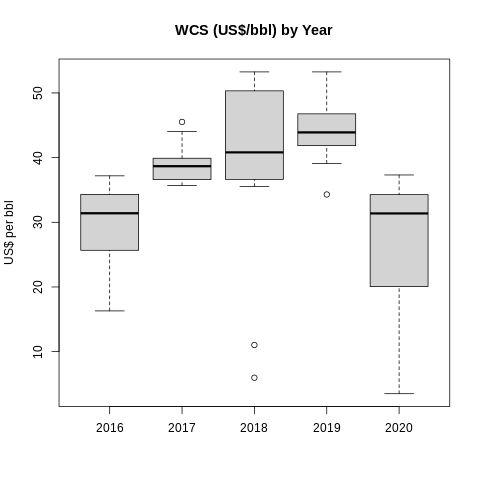

In [ ]:
%%R
boxplot(price$WCS_U ~ price$year, ylab="US$ per bbl", xlab="", main="WCS (US$/bbl) by Year")

### Plot CDN by Year -- Value of CDN relative to USD declined between 2019-2020

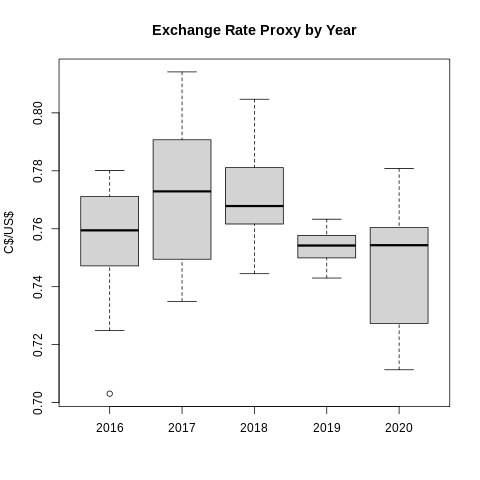

In [ ]:
%%R
boxplot(price$C_per_US ~ price$year, ylab="C$/US$", xlab="", main="Exchange Rate Proxy by Year")

### Read all five oilsands data files, between 2016-2020

In [44]:
#read oilsands data 2016-2020
%%R
oasr2020<- read_excel("oil_sands_2020_project_data.xlsx", sheet = "OASR00077", col_types = c("skip", "skip", "skip", "skip", "text", "skip", "skip", "numeric", 
"numeric",  "numeric", "skip", "skip", "skip",  "skip", "skip", "numeric","text", "numeric", "numeric", "text", "skip", "skip"))
oasr2019<- read_excel("oil_sands_2019_project_data.xlsx", sheet = "OASR00077", col_types = c("skip", "skip", "skip", "skip", "text", "skip", "skip", "numeric", 
"numeric",  "numeric", "skip", "skip", "skip",  "skip", "skip", "numeric","text", "numeric", "numeric", "text", "skip", "skip"))
oasr2018<- read_excel("oil_sands_2018_project_data.xlsx", sheet = "OASR00077", col_types = c("skip", "skip", "skip", "skip", "text", "skip", "skip", "numeric", 
"numeric",  "numeric", "skip", "skip", "skip",  "skip", "skip", "numeric","text", "numeric", "numeric", "text", "skip", "skip"))
oasr2017<- read_excel("oil_sands_2017_project_data.xlsx", sheet = "OASR00077", col_types = c("skip", "skip", "skip", "skip", "text", "skip", "skip", "numeric", 
"numeric",  "numeric", "skip", "skip", "skip",  "skip", "skip", "numeric","text", "numeric", "numeric", "text", "skip", "skip"))
oasr2016<- read_excel("oil_sands_2016_project_data.xlsx", sheet = "OASR00077", col_types = c("skip", "skip", "skip", "skip", "text", "skip", "skip", "numeric", 
"numeric",  "numeric", "skip", "skip", "skip",  "skip", "skip", "numeric","text", "numeric", "numeric", "text", "skip", "skip"))

### Concatenate (bind) above five file

In [ ]:
#Bind oilsands data 2016-2020 
%%R
new <- rbind(oasr2016, oasr2017, oasr2018, oasr2019, oasr2020)

#Make new columns
new$"NetRev_per_bbl_CDN" <- new$"Net Revenue ($)" / new$"Cleaned Crude Bitumen at RCP (barrels)"
new$"Royaly_Payable_per_bbl_CDN" <- new$"Royalty Payable ($)" / new$"Cleaned Crude Bitumen at RCP (barrels)"
new<-new%>% 
  rename(Barrels = "Cleaned Crude Bitumen at RCP (barrels)",Year="Reporting Year",GrossRevenue_CDN='Gross Revenue ($)',
         GrossRev_per_bbl_CDN="Gross Revenue ($/bbl)", RoyalyPayable_CDN= "Royalty Payable ($)",NetRevenue_CDN="Net Revenue ($)", 
         RoyaltyRate_Pct ="Royalty Rate (%)")

#If needed use: skim_without_charts() 


In [ ]:
#Inspect all the fields of the combined new file
%%R
new%>% skim_without_charts()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             594       
Number of columns          11        
_______________________              
Column type frequency:               
  character                3         
  numeric                  8         
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 Year                  0             1     4     4     0        5          0
2 Royalty Type          0             1     3     5     0        2          0
3 Payout Status         0             1     3     4     0        2          0

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable              n_missing complete_rate         mean           sd
1 GrossRevenue_CDN      

### Polot oilsands production by Year - production plataued in 2019 and slighltly declined in 2020

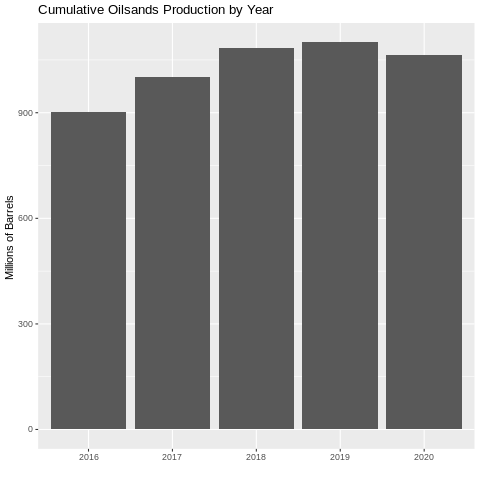

In [ ]:
#Sum Barrels
%%R
new %>% 
  group_by(Year) %>% 
  summarise(Barrels = sum(Barrels))%>% 
  ggplot(., aes(Year, Barrels/10^6)) +
  ggtitle("Cumulative Oilsands Production by Year")+
  xlab("")+ylab("Millions of Barrels ")+
  geom_col()

### Plot Producer gross revenues by Year- revenues increased in 2019; then declined steeply in 2020, similar to WCS trend (above)

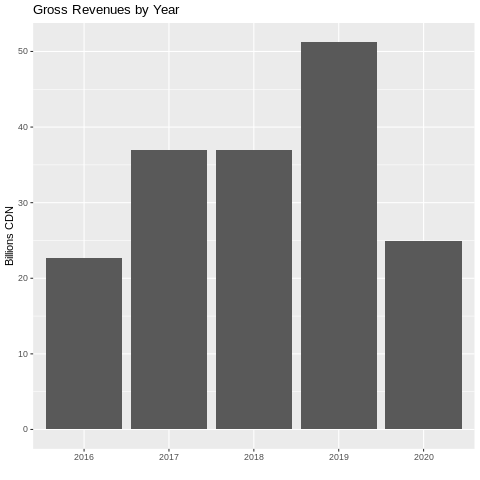

In [45]:
#Sum Gross Revenues
%%R
new %>% 
  group_by(Year) %>% 
  summarise(GrossRevenue_CDN = sum(GrossRevenue_CDN))%>% 
  ggplot(., aes(Year, GrossRevenue_CDN/10^9)) +
  ggtitle("Gross Revenues by Year")+
  xlab("")+ylab("Billions CDN")+
    geom_col()

### lot producer net revenues by Year - revenues declined more steeply, in 2020, than gross revenues did (above)

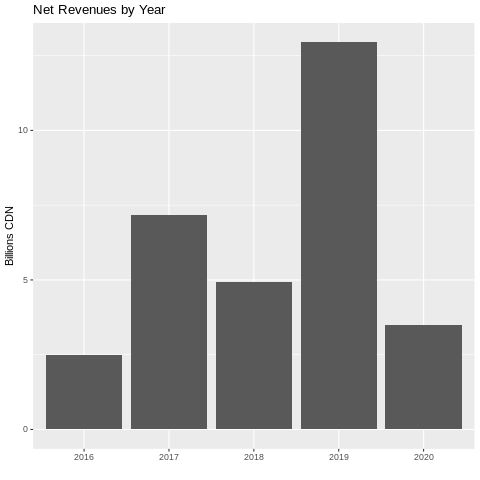

In [ ]:
#Sum of Net Revenues
%%R
new %>% 
  group_by(Year) %>% 
  summarise(NetRevenue_CDN = sum(NetRevenue_CDN))%>% 
  ggplot(., aes(Year, NetRevenue_CDN/10^9)) +
  ggtitle("Net Revenues by Year")+
  xlab("")+ylab("Billions CDN")+
  geom_col()

### Plot Royalties by Year - royalties  are postively correlated with producer net nevenues (above), a sign of a responsive royalty system

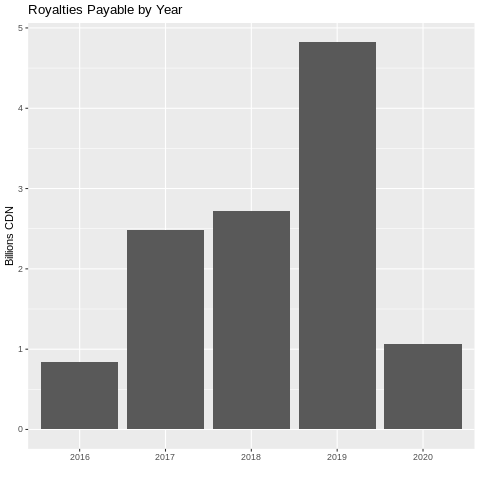

In [ ]:
#Sum Royalties Payable
%%R

new %>% 
  group_by(Year) %>% 
  summarise(RoyalyPayable_CDN = sum(RoyalyPayable_CDN))%>% 
  ggplot(., aes(Year, RoyalyPayable_CDN/10^9)) +
  ggtitle("Royalties Payable by Year")+
  xlab("")+ylab("Billions CDN")+
  geom_col()


### Tabulate royalties as share of netbacks -- the share declined in 2020, to accomodate oil price decline

In [46]:
#Royalties divided by producer net backs
%%R
new %>% 
  group_by(Year) %>% 
  summarise(Share = sum(RoyalyPayable_CDN)/sum(NetRevenue_CDN)*100)


# A tibble: 5 × 2
  Year  Share
  <chr> <dbl>
1 2016   34.0
2 2017   34.6
3 2018   55.0
4 2019   37.2
5 2020   30.4


### Tabulate projects by status and royalty type -- In 2020, 6-8 projects in 'post-payout' seem to have moved back to the 'gross revenue'  

In [ ]:
#Pay-out Status by Year
%%R
table(new$'Payout Status',new$'Year')


      
       2016 2017 2018 2019 2020
  POST   59   60   60   59   60
  PRE    61   60   60   59   56


In [47]:
#Royalty Type by Year
%%R
table(new$'Royalty Type',new$'Year')

       
        2016 2017 2018 2019 2020
  GROSS   88   84   86   82   88
  NET     32   36   34   36   28


### Merged the oilsands data set with the WCS price table, and the exchange rate proxy table, above, to run correlations

In [49]:
# Merge oilsands and median WCS 
%%R
merged2<-merge(new,MdnWCS_USD)%>% 
     merge(MdnFX) %>%

# Select a few columns to run correlations
   select(MdnWCS, NetRevenue_CDN, ,RoyalyPayable_CDN, MdnFX, Barrels)

#If needed use: skim_without_charts(merged2) 


### Plot correlation from above data set:

*   Median WCS (MdnWCS) is slightly postively correlated with producers'  net revenues, and royalty revenues 
*   MdnFX is slighlty negatively correlated with producer net revenues and royalties, meaning a weaker Canadian dollar may help improve producer revenues and royalties


In [50]:
%%R
round(cor(merged2),2)

                  MdnWCS NetRevenue_CDN RoyalyPayable_CDN MdnFX Barrels
MdnWCS              1.00           0.10              0.15  0.24    0.02
NetRevenue_CDN      0.10           1.00              0.96 -0.02    0.49
RoyalyPayable_CDN   0.15           0.96              1.00 -0.01    0.64
MdnFX               0.24          -0.02             -0.01  1.00   -0.01
Barrels             0.02           0.49              0.64 -0.01    1.00


### Plot WCS v Producer Net Revenues -- revenues increase with rising WCS

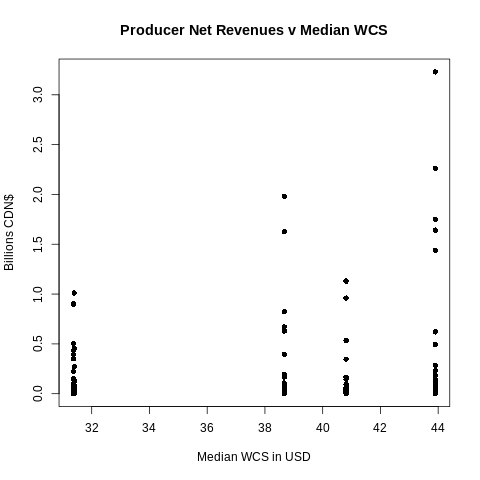

In [51]:
%%R
plot(merged2$MdnWCS, merged2$NetRevenue_CDN /10^9,
     main="Producer Net Revenues v Median WCS", xlab="Median WCS in USD", ylab="Billions CDN$", pch=16)

### Plot Royalty v Median WCS Price (US$)  -- royalties increase with rising WCS

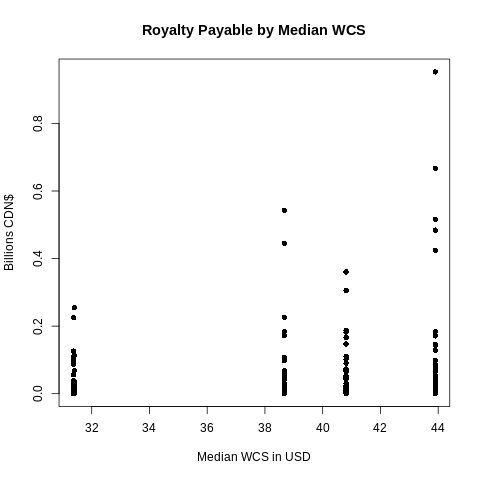

In [52]:
%%R
plot(merged2$MdnWCS, merged2$RoyalyPayable_CDN/10^9,
     main="Royalty Payable by Median WCS", xlab="Median WCS in USD", ylab="Billions CDN$", pch=16)

### Exchange Rate v Royalty payable -- a closer look

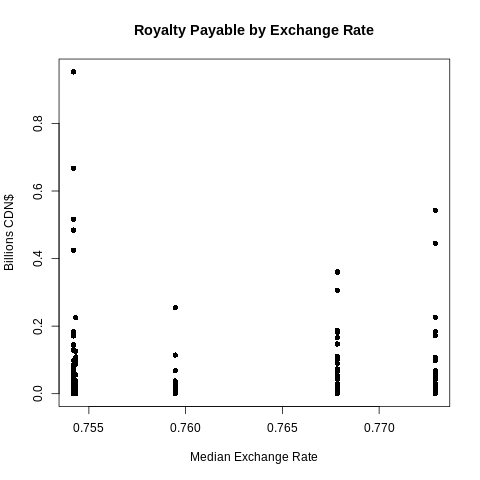

In [ ]:
%%R
plot(merged2$MdnFX, merged2$RoyalyPayable_CDN/10^9,
     main="Royalty Payable by Exchange Rate", xlab="Median Exchange Rate", ylab="Billions CDN$", pch=16) 